# Calibrating the MATILDA framework

While the last notebooks focused on data acquisition and preprocessing, we can finally start modeling. In this notebook we will...

1. ... set up a glacio-hydrological model with all the data we have collected,

2. ... run the model for the calibration period with default parameters and check the results,

3. ... use a statistical parameter optimization routine to calibrate the model,

4. ... and store the calibrated parameter set for the scenario runs in the next notebook.


The framework for Modeling water resources in glacierized catchments [MATILDA] (https://github.com/cryotools/matilda) has been developed for use in this workflow and is published as a Python package. It is based on the widely used [HBV hydrological model](https://www.cabdirect.org/cabdirect/abstract/19961904773), complemented by a temperature-index glacier melt model based on the code of [Seguinot (2019)](https://zenodo.org/record/3467639). Glacier evolution over time is simulated using a modified version of the &Delta;*h* approach following [Seibert et. al. (2018)](https://doi.org/10.5194/hess-22-2211-2018).

As before we start by loading configurations such as the calibration period and some helper functions to work with  `yaml` files.

In [41]:
from tools.helpers import update_yaml, read_yaml, write_yaml
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get output dir and date range from config.ini
dir_input = config['FILE_SETTINGS']['DIR_INPUT']
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
date_range = ast.literal_eval(config['CONFIG']['CALIBRATION_PERIOD'])
zip_output = config['CONFIG']['ZIP_OUTPUT']

print('MATILDA will be calibrated on the period ' + date_range[0] + ' to ' + date_range[1])

MATILDA will be calibrated on the period 1998-01-01 to 2020-12-31


Since HBV is a so-called 'bucket' model and all the buckets are empty in the first place we need to fill them in a setup period of minimum one year. If not specified, the first two years of the `DATE_RANGE` in the `config` are used for set up.

In [42]:
import pandas as pd

length_of_setup_period = 2

sim_start = pd.to_datetime(date_range[0]) + pd.DateOffset(years = length_of_setup_period)
set_up_end = sim_start - pd.DateOffset(days = 1)

dates = {'set_up_start': date_range[0],
         'set_up_end': str(set_up_end).split(' ')[0],        # remove hh:mm:ss
         'sim_start': str(sim_start).split(' ')[0],          # remove hh:mm:ss
         'sim_end': date_range[1]}

for key in dates.keys(): print(key + ': ' + dates[key])

set_up_start: 1998-01-01
set_up_end: 1999-12-31
sim_start: 2000-01-01
sim_end: 2020-12-31


Many MATILDA parameters have been calculated in previous notebooks and stored in `settings.yaml`. We can easily add the modeling periods using a helper function. The calculated glacier profile from Notebook 1 can be imported as a `pandas DataFrame` and added to the `settings` dictionary as well.

Finally, we will also add some optional settings that control the aggregation frequency of the outputs, the choice of graphical outputs, and more.

In [43]:
update_yaml(dir_output + 'settings.yml', dates)

remaining_settings = {"freq": "M",               # aggregation frequency of model outputs (D, M, Y)
                      "warn": False,             # show warnings of subpackages?
                      "plot_type": "all",        # interactive and/or non-interactive plots ('print', 'interactive', 'all')
                      "elev_rescaling": True}    # treat mean glacier elevation as constant or change with glacier evolution

update_yaml(dir_output + 'settings.yml', remaining_settings)

settings = read_yaml(dir_output + 'settings.yml')
glacier_profile = pd.read_csv(dir_output + 'glacier_profile.csv')
settings['glacier_profile'] = glacier_profile

print('MATILDA settings:\n\n')
for key in settings.keys(): print(key + ': ' + str(settings[key]))

Data successfully written to YAML at output/settings.yml
Data successfully written to YAML at output/settings.yml
MATILDA settings:


area_cat: 300.6637184185051
area_glac: 31.829413146586116
ele_cat: 3271.895648388366
ele_dat: 3324.5555520312164
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18511742495568
plot_type: all
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
warn: False
glacier_profile:      Elevation      Area          WE  EleZone
0         1970  0.000000      0.0000     1900
1         2000  0.000000      0.0000     2000
2         2100  0.000000      0.0000     2100
3         2200  0.000000      0.0000     2200
4         2300  0.000000      0.0000     2300
..         ...       ...         ...      ...
156       4730  0.000023  20721.3700     4700
157       4740  0.000012  14450.2180     4700
158       4750  0.000006  10551.4730     4700
159       4760  0.000000      0.0000     4700
160       4780  0.000002   6084.745

## Run MATILDA with default parameters

We will force MATILDA with the pre-processed ERA5-Land data from Notebook 2. Although MATILDA can run without calibration on observations, the results would have extreme uncertainties. Therefore, we recommend to use at least discharge observations for your selected point to evaluate the simulations against. Here, we load discharge observations for your example catchment. As you can see, we have meteorological forcing data since 1979 and discharge data since 1982. However, most of the glacier datasets used start in 2000/2001 and glaciers are a significant part of the water balance. In its current version, MATILDA is not able to extrapolate glacier cover, so we will only calibrate the model using data from 2000 onwards.

In [44]:
era5 = pd.read_csv(dir_output + 'ERA5L.csv', usecols=['dt', 'temp', 'prec'])
era5.columns = ['TIMESTAMP', 'T2', 'RRR']

# remove HH:MM:SS from 'TIMESTAMP' column
era5['TIMESTAMP'] = pd.to_datetime(era5['TIMESTAMP'])
era5['TIMESTAMP'] = era5['TIMESTAMP'].dt.date

print('ERA5 Data:')
display(era5)

obs = pd.read_csv(dir_input + 'obs_runoff_example.csv')

print('Observations:')
display(obs)

ERA5 Data:


,TIMESTAMP,T2,RRR
0,1979-01-01,257.460053,0.027150
1,1979-01-02,256.509735,0.004800
2,1979-01-03,257.944142,0.001599
3,1979-01-04,258.392049,0.281500
4,1979-01-05,258.125576,0.107802
...,...,...,...
16797,2024-12-27,263.179270,0.026296
16798,2024-12-28,259.782440,0.000917
16799,2024-12-29,261.269940,0.005262
16800,2024-12-30,263.580786,1.161816


Observations:


,Date,Qobs
0,01/01/1982,1.31
1,01/02/1982,1.19
2,01/03/1982,1.31
3,01/04/1982,1.31
4,01/05/1982,1.19
...,...,...
14240,12/27/2020,3.25
14241,12/28/2020,3.23
14242,12/29/2020,3.08
14243,12/30/2020,2.93


With all settings and input data in place, we can run MATILDA with **default parameters**.

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat               42.185117
area_cat         300.663718
area_glac         31.829413
ele_dat         3324.555552
ele_cat         3271.895648
ele_glac        4001.879883
ele_non_glac    3185.467059
warn                  False
CFR_ice                0.01
lr_temp              -0.006
lr_prec                   0
TT_snow                   0
TT_diff                   2
CFMAX_snow              2.5
CFMAX_rel                 2
BETA                    1.0
CET                    0.15
FC                      250
K0                    0.055
K1                    0.055
K2                     0.04
LP                      0.7
MAXBAS                  3.0
PERC                    1.5
UZL                     120
PCORR                   1.0
SFCF                    0

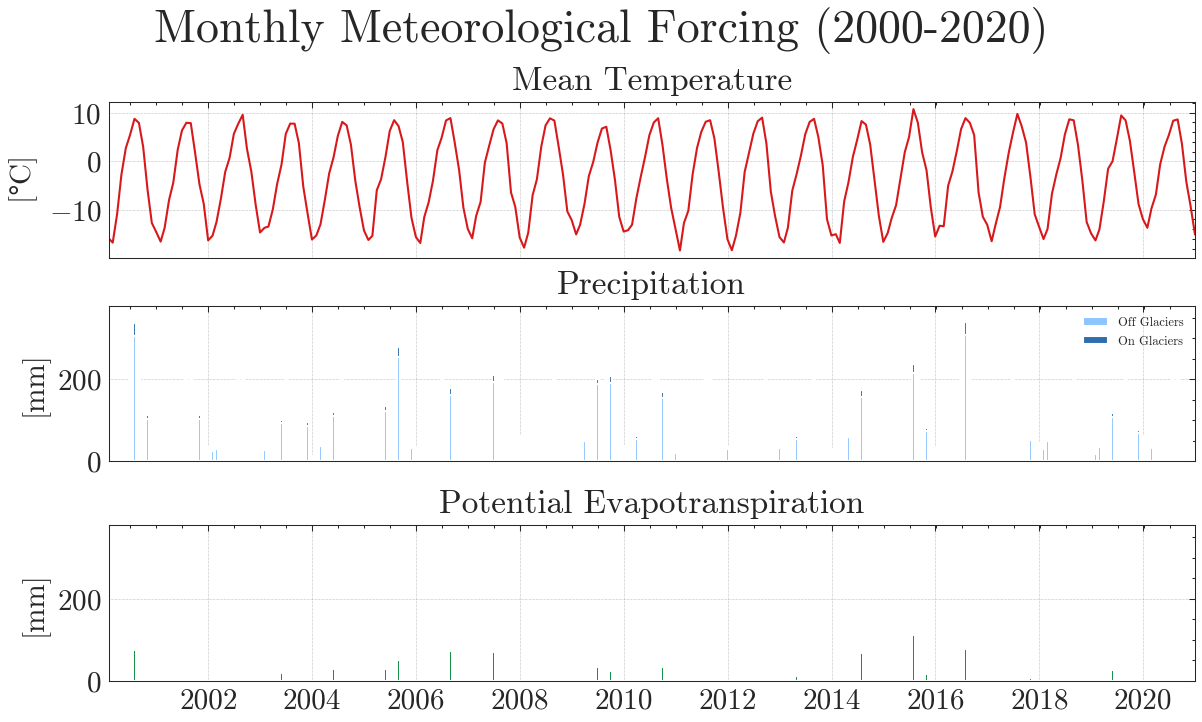

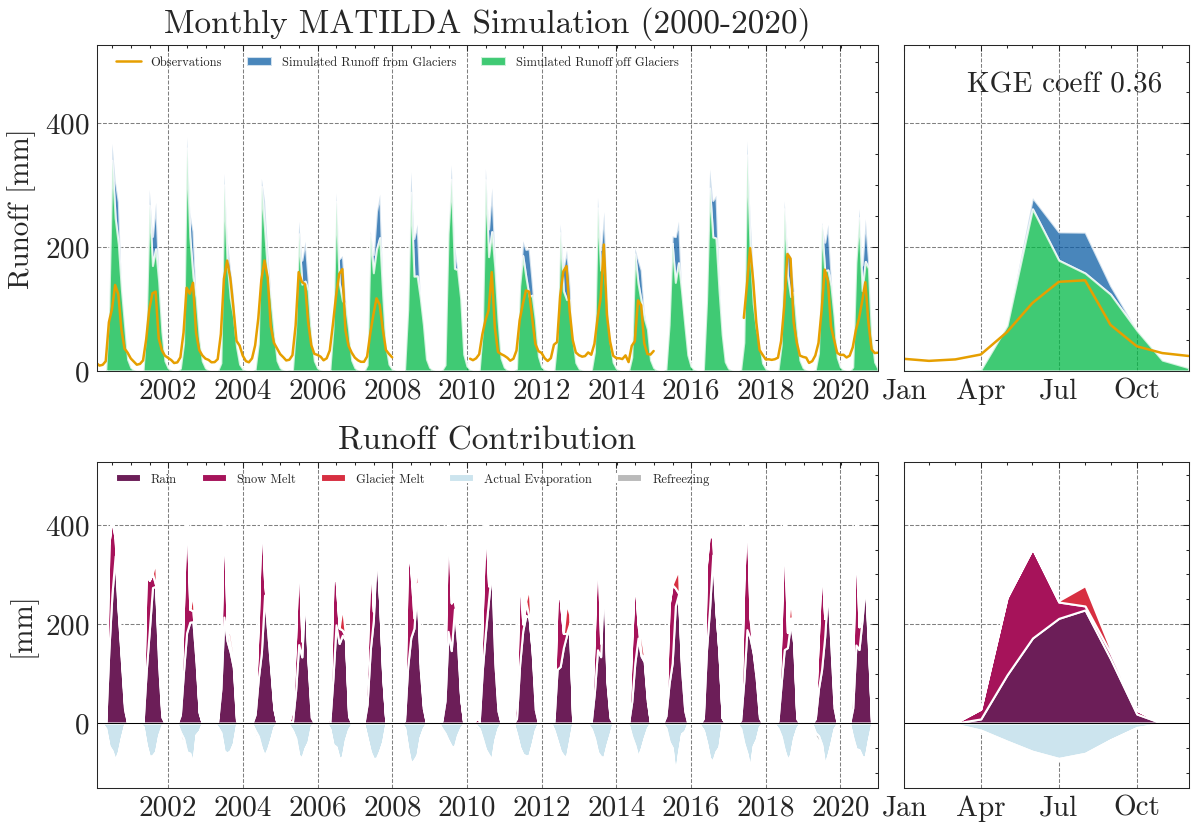

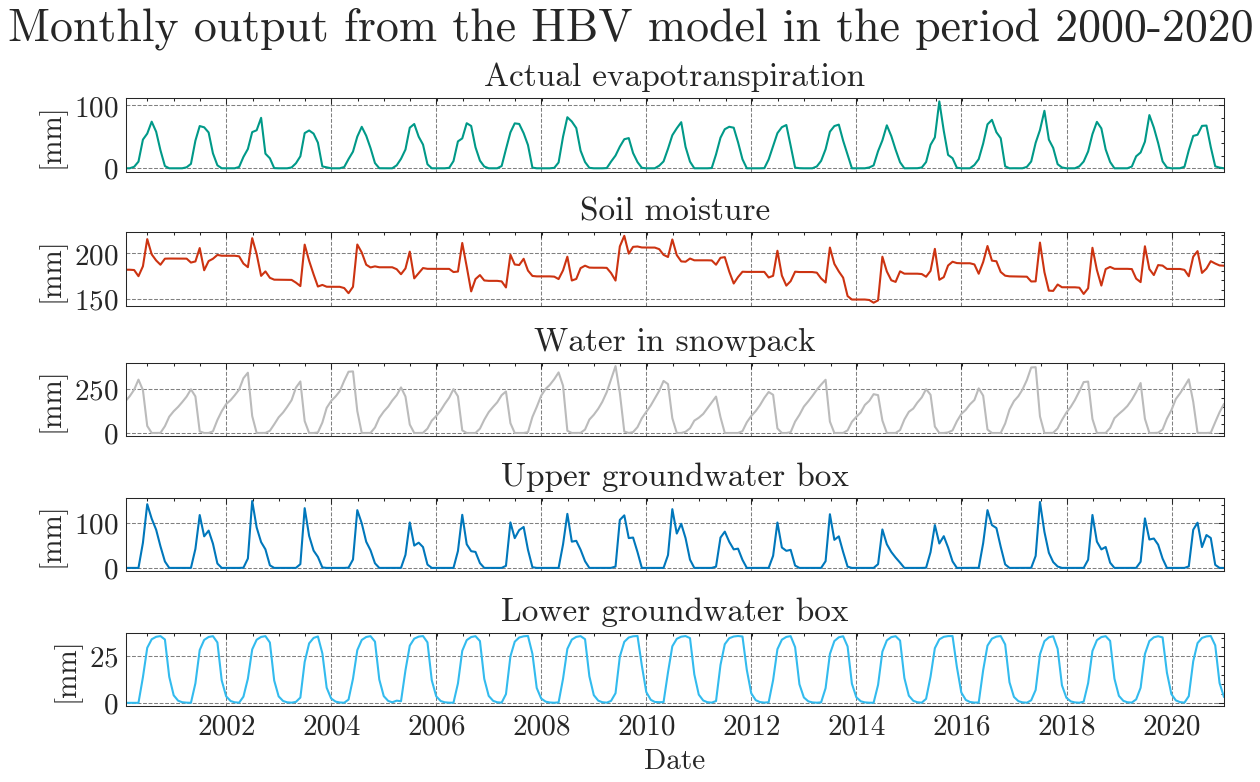

In [45]:
from matilda.core import matilda_simulation

output_matilda = matilda_simulation(era5, obs, **settings)

The results are obviously far from reality and largely overestimate runoff. The **Kling-Gupta Efficiency coefficient ([KGE](https://doi.org/10.1029/2011WR010962))** rates the result as 0.36 with 1.0 being a perfect match with the observations. We can also see that the input precipitation is much higher than the total runoff. Clearly, **the model needs calibration**.

## Calibrate MATILDA

In order to adjust the model parameters to the catchment characteristics, we will perform an **automated calibration**. The [MATILDA Python package](https://github.com/cryotools/matilda) contains a calibration module called *[matilda.mspot](https://github.com/cryotools/matilda/blob/master/matilda/mspot_glacier.py)* that makes extensive use of the Statistical Parameter Optimization Tool for Python ([SPOTPY](https://doi.org/10.1371/journal.pone.0145180)). As we have seen, there can be large uncertainties in the input data (especially precipitation). Simply tuning the model parameters to match the observed hydrograph may over- or underestimate other runoff contributors, such as glacier melt, to compensate for deficiencies in the precipitation data. Therefore, it is good practice to include additional data sets in a **multi-objective calibration**. In this workflow we will use:

- remote sensing estimates of **glacier surface mass balance** (**SMB**) and ...

- ...**snow water equivalent** (**SWE**) estimates from a dedicated snow reanalysis product.

Unfortunately, both default datasets are **limited to High Mountain Asia (HMA)**. For study sites in other areas, please consult other sources and manually add the target values for calibration in the appropriate code cells. We are happy to include additional datasets as long as they are available online and can be integrated into the workflow.

<div class="alert alert-block alert-info">
<b>Note:</b> Statistical parameter optimization (SPOT) algorithms require a high number of model runs, especially for large parameter sets. <i>mybinder.org</i> offers a maximum of two cores per user. One MATILDA calibration run for 20 years takes roughly 3s on one core. Therefore, large optimization runs in an online environment will be slow and may require you to leave the respective browser tab in the foreground for hours. To speed things up, you can either:

<div style="margin-left: 20px; margin-top: 12px;">
    ... run this notebook <b>locally on a computer with more cores</b> (ideally a high performance cluster) or <br>
    ... <b>reduce the number of calibration parameters</b> based on global sensitivity. We will return to this topic <a href="#Sensitivity-Analysis-with-FAST">later in this notebook</a>.
</div>
</div>

For now, we will demonstrate how to use the SPOT features and then **continue with a parameter set from a large HPC optimization run**. If you need help implementing the routine on your HPC, consult the [SPOTPY documentation](https://spotpy.readthedocs.io/en/latest/Advanced_hints/#mpi-parallel-computing) and [contact us](https://github.com/phiscu/matilda_edu/issues/new) if you encounter problems.

### Glacier surface mass balance data

There are various sources of SMB records but only remote sensing estimates provide data for (almost) all glaciers in the target catchment. [Shean et. al. 2020 ](https://doi.org/10.3389/feart.2019.00363) calculated geodetic mass balances for all glaciers in High Mountain Asia from 2000 to 2018. For this example (and all other catchments in HMA), we can use their data set so derive an average annual mass balance in the calibration period.

<div class="alert alert-block alert-info">
<b>Note:</b> As all remote sensing estimates the used dataset has significant uncertainties. A comparison to other datasets and the impact on the modeling results are discussed in the associated publication. </div>

We pick all individual mass balance records that match the glacier IDs in our catchment and calculate the catchment-wide mean. In addition, we use the uncertainty estimate provided in the dataset to derive an uncertainty range.

In [46]:
import pandas as pd

mass_balances = pd.read_csv(dir_input + '/hma_mb_20190215_0815_rmse.csv', usecols=['RGIId', 'mb_mwea', 'mb_mwea_sigma'])
ids = pd.read_csv(dir_output + '/RGI/Glaciers_in_catchment.csv')

merged = pd.merge(mass_balances, ids, on='RGIId')
mean_mb = round(merged['mb_mwea'].mean() * 1000, 3)   # Mean catchment MB in mm w.e.
mean_sigma = round(merged['mb_mwea_sigma'].mean() * abs(mean_mb), 3)  # Mean uncertainty of catchment MB in mm w.e.

target_mb = [mean_mb - mean_sigma, mean_mb + mean_sigma]

print('Target glacier mass balance for calibration: ' + str(mean_mb) + ' +-' + str(mean_sigma) + 'mm w.e.')

Target glacier mass balance for calibration: -155.474 +-50.3mm w.e.


### Snow water equivalent

For snow cover estimates, we will use a dedicated **snow reanalysis** dataset from [Liu et. al. 2021](https://doi.org/10.5067/HNAUGJQXSCVU). Details on the data can be found in the dataset documentation and the associated [publication](https://doi.org/10.1029/2022GL100082).
Unfortunately, access to the dataset requires a (free) registration at **NASA's EarthData** portal, which prevents a seamless integration. Also, the dataset consists of large files and requires some pre-processing that **could not be done in a Jupyter Notebook**. However, we provide you with the `SWEETR` tool, a **fully automated workflow** that you can run on your local computer to download, process, and aggregate the data. Please refer to the dedicated [Github repository](https://github.com/phiscu/hma_snow) for further instructions.

<img src="images/mean_swe_example.png" alt="Mean_SWE" width="400">

When you run the `SWEETR` tool with your catchment outline, it returns cropped raster files as the one shown above and, more importantly, a **timeseries of catchment-wide daily mean SWE** from 1999 to 2016. Just replace the `input/swe.csv` file with your result. Now we can load the timeseries as a dataframe.

In [47]:
swe = pd.read_csv(f'{dir_input}/swe.csv')

Along with the cropped SWE rasters the `SWEETR` tool creates binary masks for seasonal- and non-seasonal snow. Due to its strong signal in remote sensing data, seasonal snow can be better detected leading to more robust SWE estimates. However, the non-seasonal snow largely agrees with the glacierized area. Therefore, we will calibrate the snow routine by comparing the SWE of the ice-free sub-catchment with the seasonal snow of the reanalysis. Since the latter has a coarse resolution of 500 m, the excluded catchment area is a bit larger than the RGI glacier outlines (in the example: 17.2% non-seasonal snow vs. 10.8% glacierized sub-catchment). Therefore, we use a scaling factor to account for this mismatch in the reference area.

In [48]:
glac_ratio = settings['area_glac'] / settings['area_cat']       # read glacieriezed and total area from the settings
swe_area_sim = 1-glac_ratio
swe_area_obs = 0.828                                            # 1 - non-seasonal snow / seasonal snow
sf = swe_area_obs / swe_area_sim
print('SWE scaling factor: ' + str(round(sf, 3)))

SWE scaling factor: 0.926


The MATILDA framework provides an interface for [SPOTPY](https://github.com/thouska/spotpy/). Here we will use the `psample()` function to run MATILDA with the same settings as before but varying parameters. To do this, we will remove redundant `settings` and add some new ones specific to the function. Be sure to choose the number of repetitions carefully.
<div class="alert alert-block alert-info">
<b>Note:</b> A latin hypercube sampling with only 5 samples does not actually make sense but the number is chosen for demonstration purposes. </div>

In [49]:
from tools.helpers import drop_keys

psample_settings = drop_keys(settings, ['warn', 'plots', 'plot_type'])

additional_settings = {'rep': 5,                             # Number of model runs. For advice, check the documentation of the algorithms.
                       'glacier_only': False,                 # True when calibrating an entirely glacierized catchment
                       'obj_dir': 'maximize',                 # Maximize (e.g. NSE) or minimize (e.g. RMSE) the objective function 
                       'target_mb': mean_mb,                  # Average annual glacier mass balance to target at
                       'target_swe': swe,                     # Catchment-wide mean SWE timeseries of seasonal snow to calibrate the snow routine
                       'swe_scaling': 0.928,                  # scaling factor for simulated SWE to account for reference area mismatch
                       'dbformat': None,                      # Write the results to a file ('csv', 'hdf5', 'ram', 'sql') or not ('None')
                       'output': None,                        # Choose where to store the files
                       'algorithm': 'lhs',                    # Select the algorithm (for parallelization: mc, lhs, fast, rope, sceua or demcz)
                       'dbname': 'era5_matilda_example',      # Name the database
                       
                       'parallel': False,                     # Distribute the calculation on multiple cores or not
                      # 'cores': 20                           # Set number of cores when running in parallel
                      }
psample_settings.update(additional_settings)

print('Settings for calibration runs:\n')
for key in psample_settings.keys(): print(key + ': ' + str(psample_settings[key]))

Settings for calibration runs:

area_cat: 300.6637184185051
area_glac: 31.829413146586116
ele_cat: 3271.895648388366
ele_dat: 3324.5555520312164
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18511742495568
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
glacier_profile:      Elevation      Area          WE  EleZone  norm_elevation   delta_h
0         1970  0.000000      0.0000     1900        1.000000  1.003442
1         2000  0.000000      0.0000     2000        0.989324  0.945813
2         2100  0.000000      0.0000     2100        0.953737  0.774793
3         2200  0.000000      0.0000     2200        0.918149  0.632696
4         2300  0.000000      0.0000     2300        0.882562  0.515361
..         ...       ...         ...      ...             ...       ...
156       4730  0.000023  20721.3700     4700        0.017794 -0.000265
157       4740  0.000012  14450.2180     4700        0.014235 -0.000692
158       4750  0.0000

With these settings we can start `psample()` to run our model with various parameter combinations. The default parameter boundaries can be found in the MATILDA [parameter documentation](https://github.com/cryotools/matilda/tree/master?tab=readme-ov-file#parameter-list). If you want to narrow down the parameter space, you can do that using the following syntax. Here, we define custom ranges for the temperature lapse rate and the precipitation correction factor and run a short Latin Hypercube Sampling (LHS) for demonstration.

In [50]:
from matilda.mspot_glacier import psample

lim_dict = {'lr_temp_lo': -0.007, 'lr_temp_up': -0.005, 'PCORR_lo': 0.5, 'PCORR_up': 1.5}

best_summary = psample(df=era5, obs=obs, **psample_settings, **lim_dict)

Initializing the  Latin Hypercube Sampling (LHS)  with  5  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 5 repetitions...
Creating LatinHyperCube Matrix
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 5, maximal objective function=0.44177, time remaining: 00:00:02
4 of 5, maximal objective function=0.44177, time remaining: 00:00:00

*** Final SPOTPY summary ***
Total Duration: 6.17 seconds
Total Repetitions: 5
Maximal objective value: 0.44177
Corresponding parameter setting:
lr_temp: -0.00691643
lr_prec: 8.50519e-05
BETA: 2.21851
CET: 0.0128426
FC: 69.4315
K0: 0.105501
K1: 0.105936
K2: 0.00727363
LP: 0.472542
MAXBAS: 6.5398
PERC: 0.734797
UZL: 20.8619
PCORR: 0.909587
TT_snow: -0.758406
TT_diff: 0.993137
CFMAX_snow: 0.922814
CFMAX_rel: 1.39574
SFCF: 0.645042
CWH: 0.00853873
AG: 0.907078
CFR: 0.0586441
******************************

Best parameter set:
lr_temp=-0.006916433303633973, lr_prec=8.505193217634383e-05, BETA

In this example the function ran the model 5 times with different parameter sets and returned the one with the highest KGE score. It can be accessed from the results dictionary.

In [51]:
best_parameterset = best_summary['best_param']
# Rounding all values for readability
rounded_parameters = {key: round(value, 3) for key, value in best_parameterset.items()}
print(rounded_parameters)

{'lr_temp': -0.007, 'lr_prec': 0.0, 'BETA': 2.219, 'CET': 0.013, 'FC': 69.431, 'K0': 0.106, 'K1': 0.106, 'K2': 0.007, 'LP': 0.473, 'MAXBAS': 6.54, 'PERC': 0.735, 'UZL': 20.862, 'PCORR': 0.91, 'TT_snow': -0.758, 'TT_diff': 0.993, 'CFMAX_snow': 0.923, 'CFMAX_rel': 1.396, 'SFCF': 0.645, 'CWH': 0.009, 'AG': 0.907, 'CFR': 0.059}


Of course, to properly cover the full parameter space you would need way more repetitions. However, a high number of samples and a high KGE score don't necessarily give you the parameter set that describes the features of your catchment the best. To find the parameter combination most suitable to simulate the processes governing streamflow, we propose to calibrate MATILDA in several steps.

## Process-based calibration

Each parameter governs a different aspect of the water balance, and not all parameters influence every calibration variable. Therefore, we propose an **iterative process-based calibration** approach where we calibrate parameters in order of their importance using different algorithms, objective functions, and calibration variables. Details on the calibration strategy can be found in the model publication which is currently under review. Here, we only provide code examples with 10 samples per step for demonstration purposes. For ideal number of samples please refer to the associated publication.

<img src="images/calibration_strategy.png" alt="calibration" width="300">


### Step 1: Input correction

Three HBV parameters correct for errors in the input precipitation, snowfall, and evaporation data. They have by far the largest impact on simulated runoff and must be corrected first. The correction factors are primarily designed to correct for observational errors, such as undercatch of solid precipitation. The best way to determine these parameters depends on your study site and available observations. In this example, we disable the correction factors for snowfall (`SFCF=0`) and evaporation (`CET=0`), leaving the input data unchanged, to focus on the model's internal sensitivities rather than the input data sets. However, the ERA5-Land dataset overestimates precipitation frequency and amounts in mountainous regions. A comparison of the monthly summer precipitation (Apr-Sep) with the in-situ observations from 2008 to 2017 showed that ERA5-Land overestimates the total precipitation in the example catchment by more than 100% (`108±62%`). Since the precipitation correction factor (`PCORR`) was identified as the most influential parameter, we cannot avoid to carefully calibrate it to obtain realistic runoff rates.

To constrain `PCORR`, we split the remaining 19 parameters into two subsets:

<div style="margin-left: 20px; margin-top: 12px;margin-bottom: 12px;">
    (1) parameters governing the water balance, and<br>
    (2) those controlling runoff timing,
</div>


...with the latter set to default values. The results can then be filtered sequentially based on thresholds for $MAE_{smb}$, $KGE_{swe}$, and subsequently $KGE_{r}$. `PCORR` was set to the mean value of the posterior distribution for subsequent calibration steps.

First, we edit the settings to write results to a `.csv` file and run random sampling for the parameter subset governing the runoff amount while fixing all other parameters.

In [52]:
# Edit the settings to write results in a .csv file
psample_settings['dbformat'] = 'csv'
psample_settings['output'] = dir_output
psample_settings['dbname'] = 'calib_step1'

# Run random sampling
step1_summary = psample(
            df=era5, obs=obs, **psample_settings,
			fix_param=['SFCF', 'CET', 'FC', 'K0', 'K1', 'K2', 'MAXBAS', 'PERC', 'UZL', 'CWH', 'AG', 'LP', 'CFR'],    # fixed on defaults
			fix_val={'SFCF': 1, 'CET': 0}                                                                            # fixed on specific values
		       )

Initializing the  Latin Hypercube Sampling (LHS)  with  5  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 5 repetitions...
Creating LatinHyperCube Matrix
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calib_step1.csv' created.
2 of 5, maximal objective function=-0.390659, time remaining: 00:00:02
4 of 5, maximal objective function=0.348024, time remaining: 00:00:00

*** Final SPOTPY summary ***
Total Duration: 6.19 seconds
Total Repetitions: 5
Maximal objective value: 0.348024
Corresponding parameter setting:
lr_temp: -0.00567734
lr_prec: 0.00128468
BETA: 4.20638
PCORR: 0.667991
TT_snow: 0.959747
TT_diff: 0.723988
CFMAX_snow: 8.31543
CFMAX_rel: 1.66355
******************************

Fixed parameters:

SFCF: 1
CET: 0
FC: 250
K0: 0.055
K1: 0.055
K2: 0.04
MAXBAS: 3.0
PERC: 1.5
UZL: 120
CWH: 0.1
AG: 0.7
LP: 0.7
CFR: 0.15

NOTE: Fixed parameters are not listed in the final parameter set.

Best parameter set:


Next, we load the samples from the `.csv` file and can apply appropriate filters to the data, if desired.

In [53]:
step1_samples = pd.read_csv(f"{dir_output}calib_step1.csv")

step1_samples = step1_samples.drop(['chain'], axis=1)
step1_samples.columns = ['KGE_Runoff', 'MAE_SMB', 'KGE_SWE'] + list(step1_samples.columns[3:])
step1_samples.columns = step1_samples.columns.str.replace('par', '')

# Apply appropriate filters
#step1_samples = step1_samples[step1_samples['KGE_Runoff'] > 0.5]
#step1_samples = step1_samples[step1_samples['MAE_SMB'] < 100]
#step1_samples = step1_samples[step1_samples['KGE_SWE'] > 0.7]

print(step1_samples)

   KGE_Runoff     MAE_SMB   KGE_SWE   lr_temp   lr_prec      BETA     PCORR  \
0   -0.390659  1073.24170 -2.261153 -0.006388  0.001160  2.985225  1.369155   
1   -1.316510   320.15020 -2.751702 -0.005921  0.000226  3.895593  1.733987   
2    0.348025  2252.76320  0.486708 -0.005677  0.001285  4.206376  0.667991   
3   -0.113842   794.07630 -0.609412 -0.005858  0.001646  1.567730  1.094947   
4   -0.721091    77.41376 -1.726754 -0.006103  0.000795  5.106836  1.462764   

    TT_snow   TT_diff  CFMAX_snow  CFMAX_rel  
0 -0.314071  1.658873    1.564831   1.858126  
1  0.232515  1.783685    6.005065   1.517305  
2  0.959747  0.723988    8.315428   1.663549  
3  0.419109  1.293263    6.597863   1.289595  
4 -1.165138  2.145316    4.268604   1.713474  


We then plot the posterior distributions for each parameter.
<div class="alert alert-block alert-info">
<b>Note:</b> For very few samples they are likely to look very similar.</div>

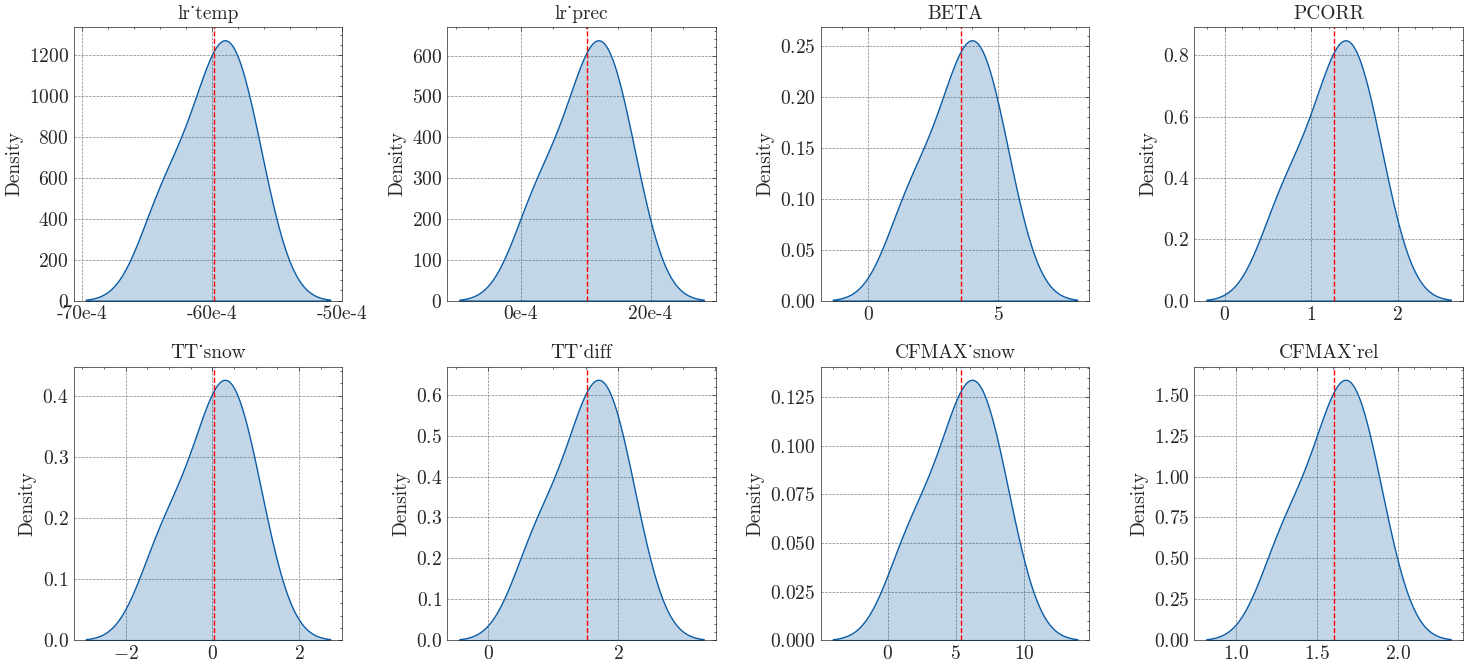

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Create a 2x4 matrix of subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

# Plot posterior distributions for each parameter in the matrix of subplots
for i, parameter in enumerate(step1_samples.columns[3:]):  # Exclude the first two columns
    row = i // 4
    col = i % 4
    sns.kdeplot(step1_samples[parameter], fill=True, ax=axs[row, col])
    axs[row, col].set_xlabel(None)
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_title(f'{parameter}', fontweight='bold', fontsize=14)
    if parameter in [step1_samples.columns[3], step1_samples.columns[4]]:
        def format_ticks(x, _):
            return '{:.0f}e-4'.format(x * 10000)  # Adjust multiplier here for desired scientific notation
        axs[row, col].xaxis.set_major_formatter(FuncFormatter(format_ticks))
    # Add vertical lines for mean, mean ± standard deviation
    mean_val = step1_samples[parameter].mean()
    std_val = step1_samples[parameter].std()
    axs[row, col].axvline(mean_val, color='red', linestyle='--', label='Mean')

plt.tight_layout()
plt.show()

Finally, we calculate the mean and standard deviation for each parameter and write the results to a table.

In [55]:
# Calculate mean and standard deviation for each column
stats_dict = {}
for col in step1_samples.columns[2:]:
    mean = step1_samples[col].mean()
    std = step1_samples[col].std()
    stats_dict[col + "_mean"] = round(mean, 5)
    stats_dict[col + "_stddev"] = round(std, 5)

# Write to table
table_step1_samples = []
for col in step1_samples.columns[:]:
    mean = step1_samples[col].mean()
    std = step1_samples[col].std()
    table_step1_samples.append([round(mean, 5), round(std, 5)])

table_df = pd.DataFrame(table_step1_samples, columns=['Mean', 'Stdv'], index=step1_samples.columns)
print(table_df[3:])

               Mean     Stdv
lr_temp    -0.00599  0.00027
lr_prec     0.00102  0.00054
BETA        3.55235  1.34372
PCORR       1.26577  0.40474
TT_snow     0.02643  0.80677
TT_diff     1.52103  0.53965
CFMAX_snow  5.35036  2.56305
CFMAX_rel   1.60841  0.21586


With an appropriate number of samples, these values will give you a good idea of the parameter distribution. In our example study, we'll fix `PCORR` and few insensitive parameters (`lr_temp`, `lr_prec`; see the <a href="#Sensitivity-Analysis-with-FAST">Sensitivity Section</a> for details) on their mean values and use the standard deviation of the other parameters to define the bounds for subsequent calibration steps. The insensitive refreezing parameter `CFR` is fixed on it's default value (0.15).

### Step 2: Snow routine calibration

Three of the remaining parameters control the snow routine: `TT_snow`, `TT_diff`, and `CFMAX_snow`. These parameters affect how snow accumulation and melting are simulated, making them critical for high mountain catchments. We repeat the procedure of step 1, but additionally fix all previously calibrated parameters. The results can then be filtered based on **$KGE_{swe}$**. As before, the selected snow routine parameters are set to the mean of the posterior distribution for use in subsequent calibration steps.

Initializing the  Latin Hypercube Sampling (LHS)  with  5  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 5 repetitions...
Creating LatinHyperCube Matrix
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calib_step2.csv' created.
2 of 5, maximal objective function=0.489585, time remaining: 00:00:02
4 of 5, maximal objective function=0.489585, time remaining: 00:00:00

*** Final SPOTPY summary ***
Total Duration: 6.28 seconds
Total Repetitions: 5
Maximal objective value: 0.489585
Corresponding parameter setting:
TT_snow: -0.350142
TT_diff: 0.880536
CFMAX_snow: 2.30342
******************************

Fixed parameters:

PCORR: 0.58
SFCF: 1
CET: 0
lr_temp: -0.0061
lr_prec: 0.0015
K0: 0.055
LP: 0.7
MAXBAS: 3.0
CFMAX_rel: 2
CFR: 0.15
FC: 250
K1: 0.055
K2: 0.04
PERC: 1.5
UZL: 120
CWH: 0.1
AG: 0.7
BETA: 1.0

NOTE: Fixed parameters are not listed in the final parameter set.

Best parameter set:
TT_snow=-0.35014173, T

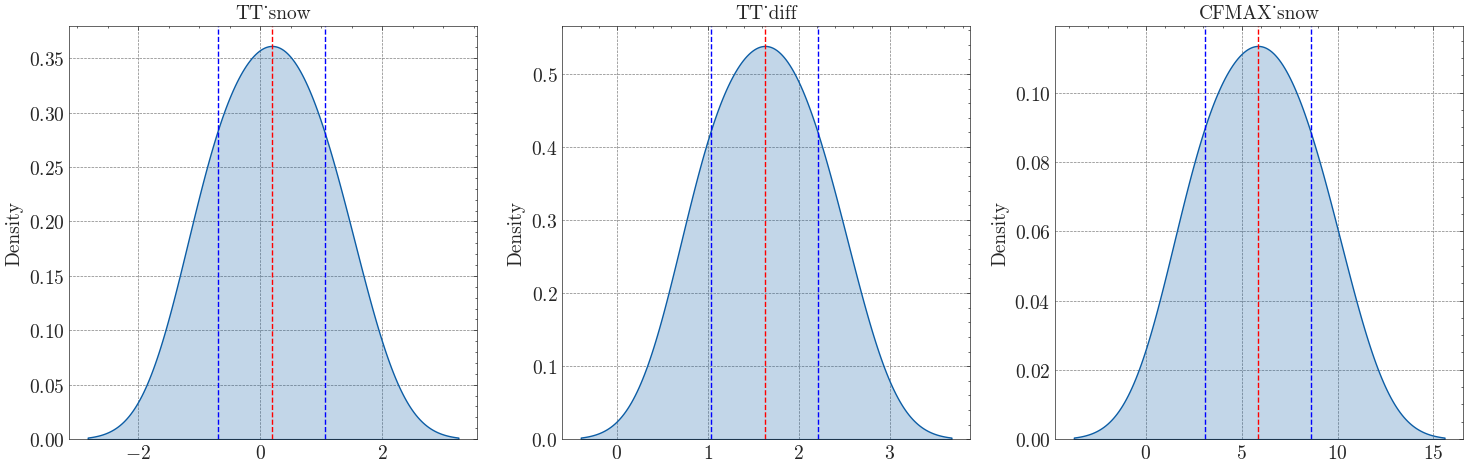


Calibrated values:
               Mean     Stdv
TT_snow     0.18864  0.87583
TT_diff     1.62704  0.58751
CFMAX_snow  5.84661  2.78856


In [56]:
# New database name
psample_settings['dbname'] = 'calib_step2'

# Running LHS with only three open parameters
step1_summary = psample(
                df=era5, obs=obs, **psample_settings,
		        fix_param=['PCORR', 'SFCF', 'CET', 'lr_temp', 'lr_prec', 'K0', 'LP', 'MAXBAS', 'CFMAX_rel', 'CFR', 'FC', 'K1', 'K2', 'PERC', 'UZL', 'CWH', 'AG', 'BETA'],
		        fix_val={'PCORR': 0.58, 'SFCF': 1, 'CET': 0, 'lr_temp': -0.0061, 'lr_prec': 0.0015, 'CFR': 0.15},
		       )

# Reading the samples from file
step2_samples = pd.read_csv(f"{dir_output}calib_step2.csv")
step2_samples = step2_samples.drop(['chain'], axis=1)
step2_samples.columns = ['KGE_Runoff', 'MAE_SMB', 'KGE_SWE'] + list(step2_samples.columns[3:])
step2_samples.columns = step2_samples.columns.str.replace('par', '')

# Apply appropriate filters
#step2_samples = step2_samples[step2_samples['KGE_SWE'] > 0.8]

# Create a 1x3 matrix of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# Plot posterior distributions for each parameter in the matrix of subplots
for i, parameter in enumerate(step2_samples.columns[3:6]):  # Exclude the first two columns
    sns.kdeplot(step2_samples[parameter], shade=True, ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'{parameter}', fontweight='bold', fontsize=14)
    # Add vertical lines for mean, mean ± standard deviation
    mean_val = step2_samples[parameter].mean()
    std_val = step2_samples[parameter].std()
    axs[i].axvline(mean_val, color='red', linestyle='--', label='Mean')
    axs[i].axvline(mean_val - std_val, color='blue', linestyle='--', label='Mean - SD')
    axs[i].axvline(mean_val + std_val, color='blue', linestyle='--', label='Mean + SD')
plt.tight_layout()
plt.show()

# Calculate mean and standard deviation for each parameter
stats_dict = {}
for col in step2_samples.columns[2:]:
    mean = step2_samples[col].mean()
    std = step2_samples[col].std()
    stats_dict[col + "_mean"] = round(mean, 5)
    stats_dict[col + "_stddev"] = round(std, 5)

# Write to table
table_step2_samples = []
for col in step2_samples.columns[:]:
    mean = step2_samples[col].mean()
    std = step2_samples[col].std()
    table_step2_samples.append([round(mean, 5), round(std, 5)])

table_df = pd.DataFrame(table_step2_samples, columns=['Mean', 'Stdv'], index=step2_samples.columns)

# Show calibrated values
print('\nCalibrated values:')
print(table_df[3:])

### Step 3: Glacier routine calibration


Since we already calibrated the snow routine, there is only one parameter left that controls glacier evolution: the ice melt rate `CFMAX_ice`. Since the melt rate for ice is higher than the one for snow due to differences in albedo, the parameter is calculated from the snow melt rate using a factor `CFMAX_rel`. We will therefore calibrate this factor instead of `CFMAX_ice` directly.

As before, we draw stratified random samples using the LHS algorithm and filter for a mean absolute error ($\text{MAE}$) threshold around the target SMB. To account for the large uncertainties in the remote sensing estimates for the SMB, we don't fix the ice melt rate but constrain it to a range that lies with the uncertainty band of the dataset.

In [57]:
# New database name
psample_settings['dbname'] = 'calib_step3'

# Running LHS with only one open parameter
step3_summary = psample(
                        df=era5, obs=obs, **psample_settings,
                        fix_param=['PCORR', 'SFCF', 'CET', 'lr_temp', 'lr_prec', 'K0', 'LP', 'MAXBAS', 'CFR', 'FC', 'K1', 'K2', 'PERC', 'UZL', 'CWH', 'AG', 'BETA', 'TT_snow', 'TT_diff', 'CFMAX_snow'],
                        fix_val={'PCORR': 0.58, 'SFCF': 1, 'CET': 0, 'lr_temp': -0.0061, 'lr_prec': 0.0015, 'CFR': 0.15, 'TT_snow': -1.45, 'TT_diff': 0.76, 'CFMAX_snow': 3.37}
)

# Reading the samples from file
step3_samples = pd.read_csv(f"{dir_output}calib_step3.csv")
step3_samples = step3_samples.drop(['chain'], axis=1)
step3_samples.columns = ['KGE_Runoff', 'MAE_SMB', 'KGE_SWE'] + list(step3_samples.columns[3:])
step3_samples.columns = step3_samples.columns.str.replace('par', '')

# Apply appropriate filters
#step3_samples = step3_samples[step3_samples['MAE_SMB'] < 100

# Use the range of values that meet the target SMB range as bound for the next calibration steps
print('\nCalibrated values:')
print(f"CFMAX_rel lower bound: {step3_samples['CFMAX_rel'].min()}\nCFMAX_rel upper bound: {step3_samples['CFMAX_rel'].max()}")

Initializing the  Latin Hypercube Sampling (LHS)  with  5  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 5 repetitions...
Creating LatinHyperCube Matrix
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calib_step3.csv' created.
2 of 5, maximal objective function=0.563832, time remaining: 00:00:02
4 of 5, maximal objective function=0.563953, time remaining: 00:00:00

*** Final SPOTPY summary ***
Total Duration: 6.4 seconds
Total Repetitions: 5
Maximal objective value: 0.563953
Corresponding parameter setting:
CFMAX_rel: 1.42308
******************************

Fixed parameters:

PCORR: 0.58
SFCF: 1
CET: 0
lr_temp: -0.0061
lr_prec: 0.0015
K0: 0.055
LP: 0.7
MAXBAS: 3.0
CFR: 0.15
FC: 250
K1: 0.055
K2: 0.04
PERC: 1.5
UZL: 120
CWH: 0.1
AG: 0.7
BETA: 1.0
TT_snow: -1.45
TT_diff: 0.76
CFMAX_snow: 3.37

NOTE: Fixed parameters are not listed in the final parameter set.

Best parameter set:
CFMAX_rel=1.4230833
Run numb

### Step 4: Soil and routing routine calibration


In the last step we calibrate the remaining 11 parameters controlling the soil, response, and routing routines all at once. Since this leads to a large parameter space, we apply the Differential Evolution Markov Chain algorithm (DEMCz). This technique is more efficient at finding global optima than other Monte Carlo Markov Chain (MCMC) algorithms and does not require prior distribution information.

However, the algorithm is sensitive to informal likelihood functions such as the $\text{KGE}$. To mitigate this problem, we use an adapted version based on the gamma-distribution (`loglike_kge`).

In [58]:
from matilda.mspot_glacier import loglike_kge

# New database name
psample_settings['dbname'] = 'calib_step4'

# Change algorithm
psample_settings['algorithm'] = 'demcz'

# The algorithm needs a minimum sample size to run through
psample_settings['rep'] = 30

# Running DEMCz with 11 open parameters
step4_summary = psample(
                df=era5, obs=obs, **psample_settings,
                # obj_func=loglike_kge,
                # Optional arguments specific to the algorithm. Use for large sample sizes only!
#		        demcz_args={'burnIn': 500, 'thin': 1, 'convergenceCriteria': 0.8},
		        fix_param=['PCORR', 'SFCF', 'CET', 'CFR', 'lr_temp', 'lr_prec', 'TT_diff', 'TT_snow', 'CFMAX_snow'],
		        fix_val={
				    # Fix:
				    'CFR': 0.15,
				    'SFCF': 1,
				    'CET': 0,

				    # Step 1:
				    'PCORR': 0.58,
				    'lr_temp': -0.006,
				    'lr_prec': 0.0015,

				    # Step 2:
				    'TT_diff': 0.76198,
				    'TT_snow': -1.44646,
				    'CFMAX_snow': 3.3677
				},
                    # Step 3:
                    CFMAX_rel_lo=1.2000372,
                    CFMAX_rel_up=1.5314099
)

Initializing the  Differential Evolution Markov Chain (DE-MC) algorithm  with  30  repetitions
The objective function will be maximized
Starting the DEMCz algotrithm with 30 repetitions...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calib_step4.csv' created.
2 of 30, maximal objective function=0.112952, time remaining: 00:00:24
4 of 30, maximal objective function=0.278135, time remaining: 00:00:26
6 of 30, maximal objective function=0.278135, time remaining: 00:00:25
8 of 30, maximal objective function=0.412269, time remaining: 00:00:24
10 of 30, maximal objective function=0.412269, time remaining: 00:00:22
12 of 30, maximal objective function=0.412269, time remaining: 00:00:20
14 of 30, maximal objective function=0.412269, time remaining: 00:00:18
16 of 30, maximal objective function=0.412269, time remaining: 00:00:15
18 of 30, maximal objective function=0.412269, time remaining: 00:00:13
20 of 30, maximal objective function=0.412269, time

Again, we can apply various criteria to filter the samples, e.g. for the glacier mass balance ($MAE_{smb}$) and runff ($KGE_{r}$).

In [59]:
# Reading the samples from file
step4_samples = pd.read_csv(f"{dir_output}calib_step4.csv")
step4_samples = step4_samples.drop(['chain'], axis=1)
step4_samples.columns = ['KGE_Runoff', 'MAE_SMB', 'KGE_SWE'] + list(step4_samples.columns[3:])

# Apply appropriate filters
# data = data[data['KGE_Runoff'] > 800]            # loglike_KGE values rough equivalents: 700 =~0.85    max. 895 =~0.87
# data = data[data['MAE_SMB'] < 50]

We can now plot the posterior distribution of all 11 parameters and the calibration variables.

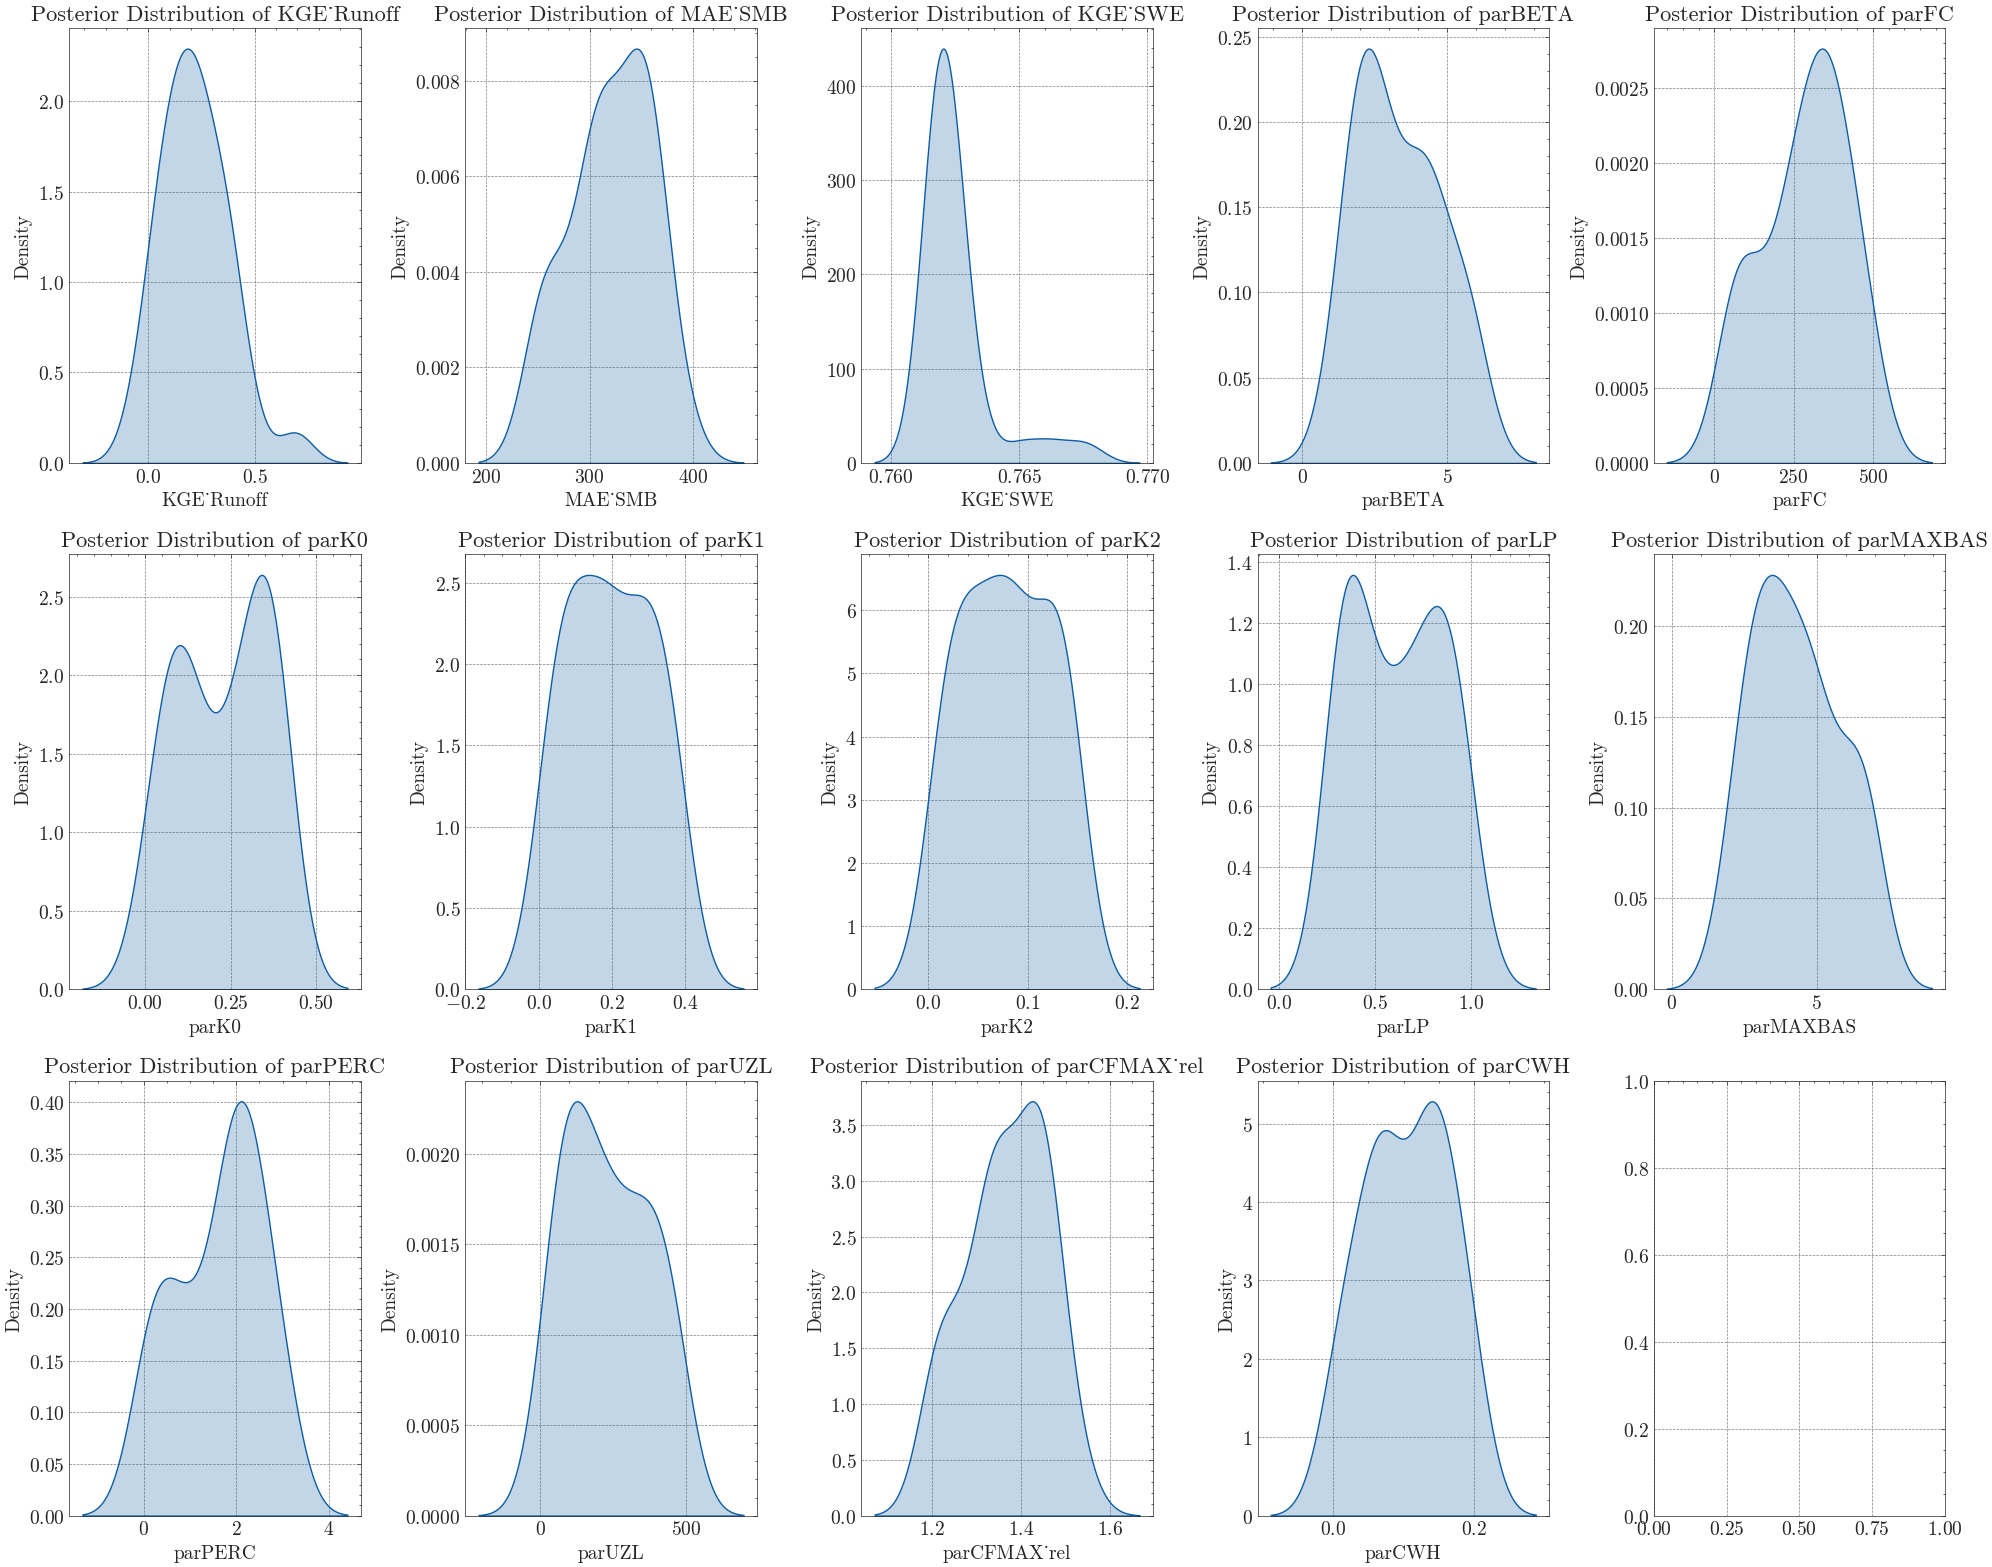

In [60]:
# Create a 3x5 matrix of subplots
fig, axs = plt.subplots(3, 5, figsize=(20, 16))

# Plot posterior distributions for each parameter in the matrix of subplots
for i, parameter in enumerate(step4_samples.columns[:-1]):  # Exclude the 'chain' column
    row = i // 5
    col = i % 5
    sns.kdeplot(step4_samples[parameter], shade=True, ax=axs[row, col])
    axs[row, col].set_xlabel(parameter)
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_title(f'Posterior Distribution of {parameter}')

plt.tight_layout()
plt.show()

Depending on your sample size and filter criteria, there might still be a large number of possible parameter sets. To identify the best sample, you can either apply further criteria (e.g. seasonal $\text{KGE}$ scores) or use visual methods.

In [61]:
import plotly.graph_objects as go
custom_text = [f'Index: {index}<br>KGE_Runoff: {KGE_Runoff}<br>MAE_SMB: {MAE_SMB}' for (index, KGE_Runoff, MAE_SMB) in
               zip(step4_samples.index, step4_samples['KGE_Runoff'], step4_samples['MAE_SMB'])]

# Create a 2D scatter plot with custom text
fig = go.Figure(data=go.Scatter(
    x=step4_samples['KGE_Runoff'],
    y=step4_samples['MAE_SMB'],
    mode='markers',
    text=custom_text, # Assign custom text to each step4_samples point
    hoverinfo='text',  # Show custom text when hovering
))

# Update layout
fig.update_layout(
    xaxis_title='Kling-Gupta-Efficiency score',
    yaxis_title='MAE of mean annual SMB',
    #title='2D Scatter Plot of like1 and like2 with parPCORR Color Ramp',
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins for better visualization
)

# Show the plot
fig.show()

When you identified the best run, you can get the respective parameter set using the index number (e.g run number 10).

In [62]:
# Select ID of your best run
best = step4_samples[step4_samples.index == 10]                     # change accordingly

# Filter columns with the prefix 'par'
par_columns = [col for col in best.columns if col.startswith('par')]

# Create a dictionary with keys as column names without the 'par' prefix
parameters = {col.replace('par', ''): best[col].values[0] for col in par_columns}

# Print the dictionary
print(parameters)

{'BETA': 1.0896775, 'FC': 91.535614, 'K0': 0.39396313, 'K1': 0.091763765, 'K2': 0.14183621, 'LP': 0.34399354, 'MAXBAS': 3.5683568, 'PERC': 0.66150236, 'UZL': 410.74466, 'CFMAX_rel': 1.215003, 'CWH': 0.08377623, 'AG': 0.5709083}


Together with your parameter values from previous steps, this is your calibrated parameter set you can use to run the projections.

This incremental calibration allows linking the parameters to the processes simulated instead of randomly fitting them to match the measured discharge. However, uncertainties in the calibration data still allow for a wide range of potential scenarios. For a detailed discussion please refer to the associated publication.

## Run MATILDA with calibrated parameters

The following parameter set was computed applying the mentioned calibration strategy on an HPC cluster with large sample sizes for every step.
<a id="param"></a>

In [63]:
param = {
    'CFR': 0.15,
    'SFCF': 1,
    'CET': 0,
    'PCORR': 0.58,
    'lr_temp': -0.006,
    'lr_prec': 0.0015,
    'TT_diff': 0.76198,
    'TT_snow': -1.44646,
    'CFMAX_snow': 3.3677,
    'BETA': 1.0,
    'FC': 99.15976,
    'K0': 0.01,
    'K1': 0.01,
    'K2': 0.15,
    'LP': 0.998,
    'MAXBAS': 2.0,
    'PERC': 0.09232826,
    'UZL': 126.411575,
    'CFMAX_rel': 1.2556936,
    'CWH': 0.000117,
    'AG': 0.54930484
}

print('Calibrated parameter set:\n\n')
for key in param.keys(): print(key + ': ' + str(param[key]))

Calibrated parameter set:


CFR: 0.15
SFCF: 1
CET: 0
PCORR: 0.58
lr_temp: -0.006
lr_prec: 0.0015
TT_diff: 0.76198
TT_snow: -1.44646
CFMAX_snow: 3.3677
BETA: 1.0
FC: 99.15976
K0: 0.01
K1: 0.01
K2: 0.15
LP: 0.998
MAXBAS: 2.0
PERC: 0.09232826
UZL: 126.411575
CFMAX_rel: 1.2556936
CWH: 0.000117
AG: 0.54930484


Properly calibrated, the model shows a much better results.

---
MATILDA framework
Reading parameters for MATILDA simulation
Parameter set:
set_up_start     1998-01-01
set_up_end       1999-12-31
sim_start        2000-01-01
sim_end          2020-12-31
freq                      M
freq_long           Monthly
lat               42.185117
area_cat         300.663718
area_glac         31.829413
ele_dat         3324.555552
ele_cat         3271.895648
ele_glac        4001.879883
ele_non_glac    3185.467059
warn                  False
CFR_ice                0.01
lr_temp              -0.006
lr_prec              0.0015
TT_snow            -1.44646
TT_diff             0.76198
CFMAX_snow           3.3677
CFMAX_rel          1.255694
BETA                    1.0
CET                       0
FC                 99.15976
K0                     0.01
K1                     0.01
K2                     0.15
LP                    0.998
MAXBAS                  2.0
PERC               0.092328
UZL              126.411575
PCORR                  0.58
SFCF                     

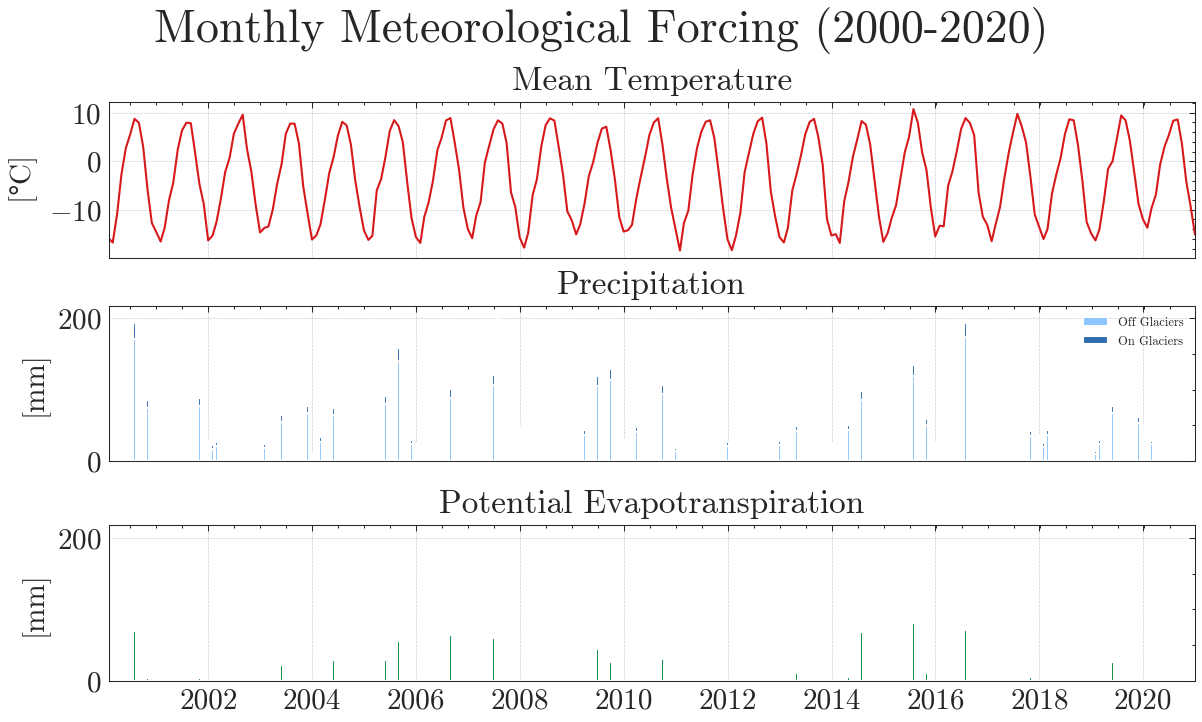

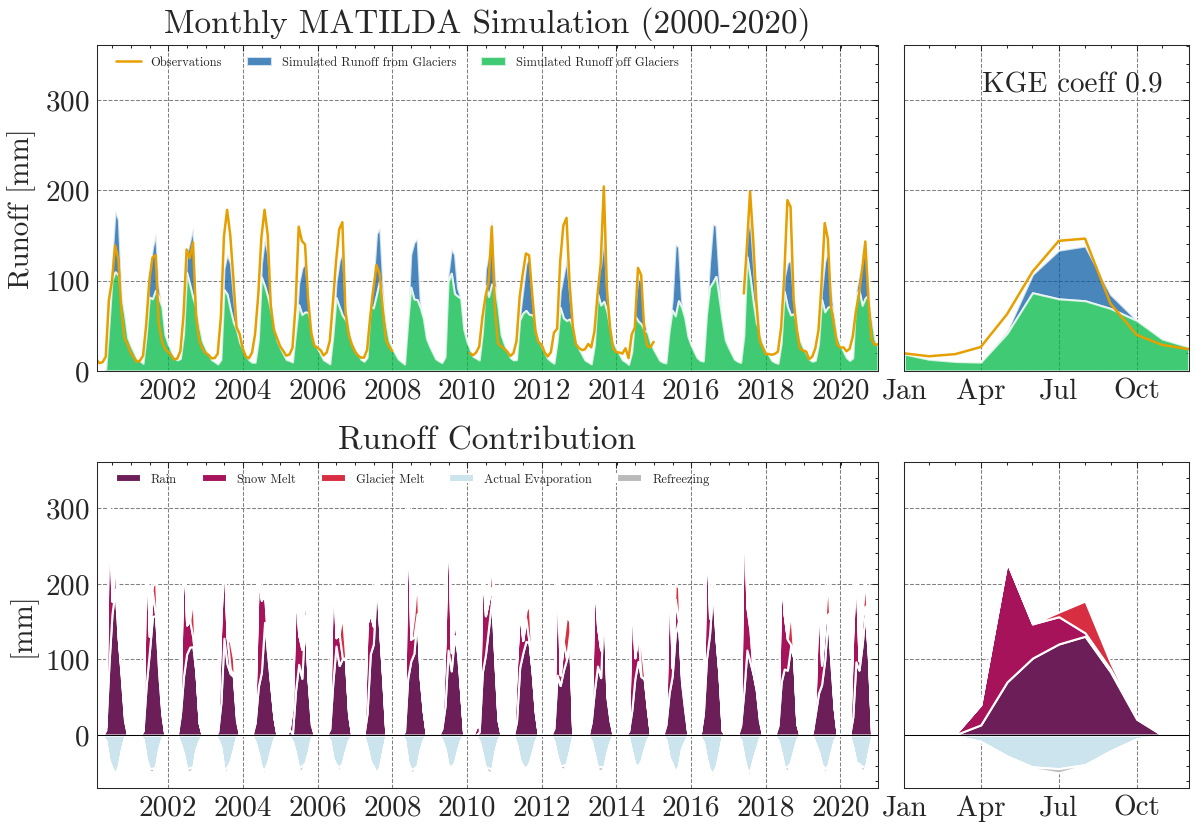

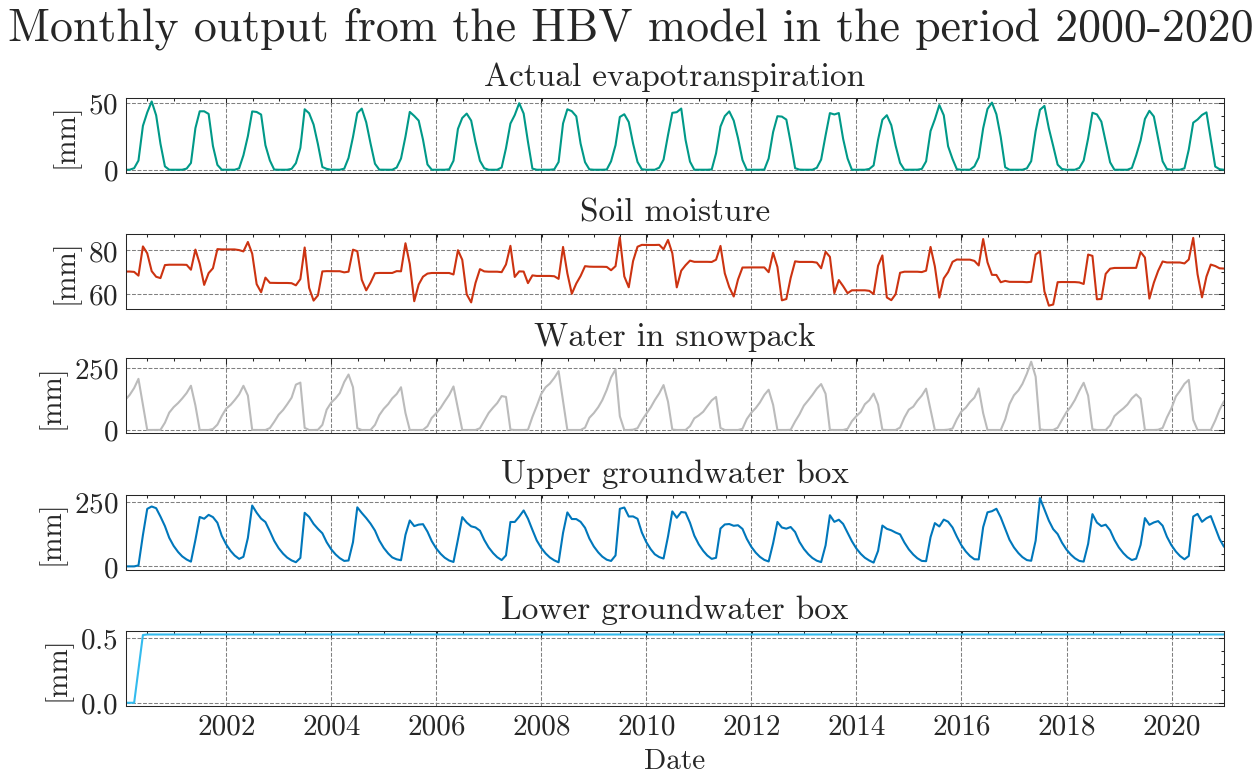

In [64]:
output_matilda = matilda_simulation(era5, obs, **settings, **param)

In addition to the standard plots we can explore the results interactive `ploty` plots. Go ahead and zoom as you like or select/deselect individual curves.

In [65]:
output_matilda[9].show()

The same works for the long-term seasonal cycle.

In [66]:
output_matilda[10].show()

## Sensitivity Analysis with FAST

To reduce the computation time of the calibration procedure, we need to reduce the number of parameters to be optimized. Therefore, we will perform a global sensitivity analysis to identify the most important parameters and set the others to default values. The algorithm of choice will be the [Fourier Amplitude Sensitivity Test (FAST)](https://www.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594) available through the [SPOTPY](https://github.com/thouska/spotpy/blob/master/src/spotpy/algorithms/fast.py) library. As before, we will show the general procedure with a few iterations, but display results from extensive runs on a HPC. You can use the results as a guide for your parameter choices, but keep in mind that they are highly correlated with your catchment properties, such as elevation range and glacier coverage.

First, we calculate the required number of iterations using a formula from [Henkel et. al. 2012](https://www.informs-sim.org/wsc12papers/includes/files/con308.pdf). We choose the SPOTPY default frequency step of 2 and set the interference factor to a maximum of 4, since we assume a high intercorrelation of the model parameters. The total number of parameters in MATILDA is 21.

In [67]:
def fast_iter(param, interf=4, freqst=2):
    """
    Calculates the number of parameter iterations needed for parameterization and sensitivity analysis using FAST.
    Parameters
    ----------
    param : int
        The number of input parameters being analyzed.
    interf : int
        The interference factor, which determines the degree of correlation between the input parameters.
    freqst : int
        The frequency step, which specifies the size of the intervals between each frequency at which the Fourier transform is calculated.
    Returns
    -------
    int
        The total number of parameter iterations needed for FAST.
    """
    return (1 + 4 * interf ** 2 * (1 + (param - 2) * freqst)) * param

print('Needed number of iterations for FAST: ' + str(fast_iter(21)))

Needed number of iterations for FAST: 52437


That is a lot of iterations! Running this routine on a single core would take about two days, but can be sped up significantly with each additional core. The setup would look exactly like the parameter optimization before.

<div class="alert alert-block alert-info">
<b>Note:</b> No matter what number of iterations you define, SPOTPY will run $N*k$ times, where $k$ is the number of model parameters. So even if we set rep=10, the algorithm will run at least 21 times.</div>

In [68]:
from matilda.mspot_glacier import psample

fast_settings = {'rep': 52437,                              # Choose wisely before running
                 'target_mb': None,
                 'algorithm': 'fast',
                 'dbname': 'fast_matilda_example',
                 'dbname': dir_output + 'fast_example',
                 'dbformat': 'csv'
                      }
psample_settings.update(fast_settings)

print('Settings for FAST:\n\n')
for key in psample_settings.keys(): print(key + ': ' + str(psample_settings[key]))

# fast_results = psample(df=era5, obs=obs, **psample_settings)

Settings for FAST:


area_cat: 300.6637184185051
area_glac: 31.829413146586116
ele_cat: 3271.895648388366
ele_dat: 3324.5555520312164
ele_glac: 4001.8798828125
elev_rescaling: True
freq: M
lat: 42.18511742495568
set_up_end: 1999-12-31
set_up_start: 1998-01-01
sim_end: 2020-12-31
sim_start: 2000-01-01
glacier_profile:      Elevation      Area          WE  EleZone  norm_elevation   delta_h
0         1970  0.000000      0.0000     1900        1.000000  1.003442
1         2000  0.000000      0.0000     2000        0.989324  0.945813
2         2100  0.000000      0.0000     2100        0.953737  0.774793
3         2200  0.000000      0.0000     2200        0.918149  0.632696
4         2300  0.000000      0.0000     2300        0.882562  0.515361
..         ...       ...         ...      ...             ...       ...
156       4730  0.000023  20721.3700     4700        0.017794 -0.000265
157       4740  0.000012  14450.2180     4700        0.014235 -0.000692
158       4750  0.000006  10551.4

We ran *FAST*s for the example catchment an an HPC with the full number of iterations required. The results are saved in *CSV* files. We can use the `spotpy.analyser` library to create easy-to-read data frames from the databases. The summary shows the first (`S1`) and the total order sensitivity index (`ST`) for each parameter. `S1` refers to the variance of the model output explained by the parameter, holding all other parameters constant. The `ST` takes into account the interaction of the parameters and is therefore a good measure of the impact of individual parameters on the model output.

In [69]:
from tools.helpers import get_si

display(get_si(dir_input + 'FAST/' + 'example_fast_nolim.csv'))

,S1,ST
param,,
lr_temp,0.001027,0.028119
lr_prec,0.000068,0.020323
BETA,0.000406,0.044880
CET,0.000183,0.061767
FC,0.000177,0.070427
K0,0.000128,0.056534
K1,0.000611,0.096560
K2,0.000564,0.073538
LP,0.000296,0.087176


If you have additional information on certain parameters, limiting their bounds can have a large impact on sensitivity. For our example catchment, field observations showed that the temperature lapse rate and precipitation correction were unlikely to exceed a certain range, so we limited the parameter space for both and ran a *FAST* again.

In [70]:
lim_dict = {'lr_temp_lo': -0.007, 'lr_temp_up': -0.005, 'PCORR_lo': 0.5, 'PCORR_up': 1.5}
# fast_results = psample(df=era5, obs=obs, **psample_settings, **lim_dict)

To see the effect of parameter restrictions on sensitivity, we can plot the indices of both runs. Feel free to explore further by adding more *FAST* outputs to the plot function.

In [71]:
from tools.plots import plot_sensitivity_bars

step1 = dir_input + 'FAST/' + 'example_fast_nolim.csv'
step2 = dir_input + 'FAST/' + 'era5_ipynb_fast_step1.csv'

plot_sensitivity_bars(step1, step2, labels=['No Limits', 'lr_temp and PCORR limited'], show=True)

From this figure, we can easily identify the most important parameters. Depending on your desired accuracy and computational resources, you can choose a sensitivity threshold. Let's say we want to fix all parameters with a sensitivity index below 0.1. For our example, this will reduce the calibration parameters to 7.

In [72]:
si_df = get_si(step2)
sensitive = si_df.index[si_df['ST'] > 0.10].values

print('Parameters with a sensitivity index > 0.1:')
for i in sensitive: print(i)

Parameters with a sensitivity index > 0.1:
K1
K2
LP
PCORR
TT_snow
CFMAX_ice
SFCF


To give you an idea how much this procedure can reduce calibration time, we run the `fast_iter()` function again.

In [73]:
print('Needed number of iterations for FAST with all parameters: ' + str(fast_iter(21)))
print('Needed number of iterations for FAST with the 7 most sensitive parameters: ' + str(fast_iter(7)))

Needed number of iterations for FAST with all parameters: 52437
Needed number of iterations for FAST with the 7 most sensitive parameters: 4935


For a single core this would roughly translate into a reduction from 44h to 4h.

To run the calibration with the reduced parameter space, we simply need to define values for the fixed parameters and use a helper function to translate them into boundary arguments. Here we simply use the values from our last *SPOTPY* run (`param`).

In [74]:
from matilda.mspot_glacier import dict2bounds

fixed_param = {key: val for key, val in param.items() if key not in sensitive}
fixed_param_bounds = dict2bounds(fixed_param)
       
print('Fixed bounds:\n')
for key in fixed_param_bounds.keys(): print(key + ': ' + str(fixed_param_bounds[key]))

Fixed bounds:

CFR_lo: 0.15
CET_lo: 0
lr_temp_lo: -0.006
lr_prec_lo: 0.0015
TT_diff_lo: 0.76198
CFMAX_snow_lo: 3.3677
BETA_lo: 1.0
FC_lo: 99.15976
K0_lo: 0.01
MAXBAS_lo: 2.0
PERC_lo: 0.09232826
UZL_lo: 126.411575
CFMAX_rel_lo: 1.2556936
CWH_lo: 0.000117
AG_lo: 0.54930484
CFR_up: 0.15
CET_up: 0
lr_temp_up: -0.006
lr_prec_up: 0.0015
TT_diff_up: 0.76198
CFMAX_snow_up: 3.3677
BETA_up: 1.0
FC_up: 99.15976
K0_up: 0.01
MAXBAS_up: 2.0
PERC_up: 0.09232826
UZL_up: 126.411575
CFMAX_rel_up: 1.2556936
CWH_up: 0.000117
AG_up: 0.54930484


The `psample()` setup is then as simple as before.

In [75]:
new_settings = {'rep': 10,                             # Number of model runs. For advice check the documentation of the algorithms.
                'glacier_only': False,                 # True when calibrating a entirely glacierized catchment
                'obj_dir': 'maximize',                 # should your objective funtion be maximized (e.g. NSE) or minimized (e.g. RMSE)
                'target_mb': -156,                     # Average annual glacier mass balance to target at
                'dbformat': None,                      # Write the results to a file ('csv', 'hdf5', 'ram', 'sql')
                'output': None,                        # Choose where to store the files
                'algorithm': 'lhs',                    # Choose algorithm (for parallelization: mc, lhs, fast, rope, sceua or demcz)
                'dbname': 'era5_matilda_example',      # Choose name
                       
                'parallel': False,                     # Distribute the calculation on multiple cores or not
                # 'cores': 20                           # Set number of cores when running parallel
                      }
psample_settings.update(new_settings)

best_summary = psample(df=era5, obs=obs, **psample_settings, **fixed_param_bounds)

Initializing the  Latin Hypercube Sampling (LHS)  with  10  repetitions
The objective function will be maximized
Starting the LHS algotrithm with 10 repetitions...
Creating LatinHyperCube Matrix
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
2 of 10, maximal objective function=0.263245, time remaining: 00:00:06
4 of 10, maximal objective function=0.374722, time remaining: 00:00:05
6 of 10, maximal objective function=0.374722, time remaining: 00:00:03
8 of 10, maximal objective function=0.374722, time remaining: 00:00:01
10 of 10, maximal objective function=0.374722, time remaining: 23:59:59

*** Final SPOTPY summary ***
Total Duration: 12.81 seconds
Total Repetitions: 10
Maximal objective value: 0.374722
Corresponding parameter setting:
lr_temp: -0.006
lr_prec: 0.0015
BETA: 1
CET: 0
FC: 99.2
K0: 0.01
K1: 0.176607
K2: 0.0343977
LP: 0.925865
MAXBAS: 2
PERC: 0.0923
UZL: 126
PCORR: 0.628819
TT_snow: -1.19722
TT_diff: 0.762
CFMAX_snow: 3.37
CFMAX_rel: 1.26
SFCF: 0.

<div class="alert alert-block alert-info">
<b>Note:</b> The number of iterations required depends on the selected algorithm and the number of free parameters. To choose the correct setting, consult the <a href='https://spotpy.readthedocs.io/en/latest/Algorithm_guide/'>SPOTPY documentation</a> and the original literature for each algorithm.</div>

Now, we save the best parameter set for use in the next notebook. The set is stored in the `best_summary` variable.

**Note:** In our example we will skip this step and use the [result from the calibration on an HPC cluster](#param).

In [76]:
# param = best_summary['best_param']

Finally, we store the parameter set in a `.yml` file.

In [77]:
write_yaml(param, dir_output + 'parameters.yml')
print(f"Parameter set stored in '{dir_output}parameters.yml'")

Data successfully written to YAML at output/parameters.yml
Parameter set stored in 'output/parameters.yml'


In [78]:
import shutil

if zip_output:
    # refresh `output_download.zip` with data retrieved within this notebook
    shutil.make_archive('output_download', 'zip', 'output')
    print('Output folder can be download now (file output_download.zip)')

Output folder can be download now (file output_download.zip)


In [79]:
%reset -f

With this calibrated parameter set, you can now continue with [Notebook 5](Notebook5_MATILDA_scenarios.ipynb) to run the calibrated model for the whole ensemble.